## This notetbook implements a U-NET architecture for colonscopy images. The goal of this project is to train an AI to analyze an image and draw an irregular shape around the cancer affected area. 

### Calling imports

In [2]:
import os
import shutil
import glob
import zipfile
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [3]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K

### Define global variables

In [6]:
original_image_path = "./data/PngFormat/Original"
ground_truth_image_path = "./data/PngFormat/GroundTruth"
train_image_path = "./data/train"
test_image_path = "./data/test"
model_output_path = "./bin/model.h5"
training_dataset_split = 0.8
image_shape = (384, 288, 3)
batch_size = 3
epochs = 200

### Preprocessing dataset

In [7]:
all_imagefile_ids = []
for file in os.listdir(original_image_path) :
    last_index_file_name = file.find(".png")
    file_name_without_ext = file[:last_index_file_name]
    all_imagefile_ids.append(file_name_without_ext)

### Shuffle the data

In [8]:
np.random.shuffle(all_imagefile_ids)

### Split the data in training and test set

In [6]:
dataset_length = len(all_imagefile_ids)

training_dataset_length = int(dataset_length * training_dataset_split)
training_dataset_ids = all_imagefile_ids[:training_dataset_length]

test_dataset_length = dataset_length - training_dataset_length
test_dataset_ids = all_imagefile_ids[-test_dataset_length:]

### Copying files to train and test folders

In [7]:
if not os.path.exists(train_image_path) :
    os.makedirs(train_image_path)
    
if not os.path.exists(test_image_path) :
    os.makedirs(test_image_path)

In [8]:
##copy files to training directory 
for filename in training_dataset_ids :
    original_image_file_path = "{}/{}.png".format(original_image_path, filename)
    ground_truth_image_file_path = "{}/{}.png".format(ground_truth_image_path, filename)
    
    dest_original_image_file_path = "{}/{}.png".format(train_image_path, filename)
    dest_ground_truth_image_file_path = "{}/{}_mask.png".format(train_image_path, filename)
    
    #copy original image to train 
    shutil.copyfile(original_image_file_path, dest_original_image_file_path)
    
    #copy ground truth image to train 
    shutil.copyfile(ground_truth_image_file_path, dest_ground_truth_image_file_path)
    
## we make sure that our training set is twice the size of 'training_dataset_ids' array
assert len(glob.glob(train_image_path + "/*")) == training_dataset_length * 2

In [9]:
##copy files to test directory 
for filename in test_dataset_ids :
    original_image_file_path = "{}/{}.png".format(original_image_path, filename)
    ground_truth_image_file_path = "{}/{}.png".format(ground_truth_image_path, filename)
    
    dest_original_image_file_path = "{}/{}.png".format(test_image_path, filename)
    dest_ground_truth_image_file_path = "{}/{}_mask.png".format(test_image_path, filename)
    
    #copy original image to train 
    shutil.copyfile(original_image_file_path, dest_original_image_file_path)
    
    #copy ground truth image to train 
    shutil.copyfile(ground_truth_image_file_path, dest_ground_truth_image_file_path)
    
## we make sure that our training set is twice the size of 'training_dataset_ids' array
assert len(glob.glob(test_image_path + "/*")) == test_dataset_length * 2

### Creating dataset

In [10]:
training_dataset_file_paths = ["{}/{}.png".format(train_image_path, filename) for filename in training_dataset_ids]
training_dataset_masks_file_paths = ["{}/{}_mask.png".format(train_image_path, filename) for filename in training_dataset_ids]

test_dataset_file_paths = ["{}/{}.png".format(test_image_path, filename) for filename in test_dataset_ids]
test_dataset_masks_file_paths = ["{}/{}_mask.png".format(test_image_path, filename) for filename in test_dataset_ids]

### Visualize some images

### Process each original file and the corresponding mask file for our dataset

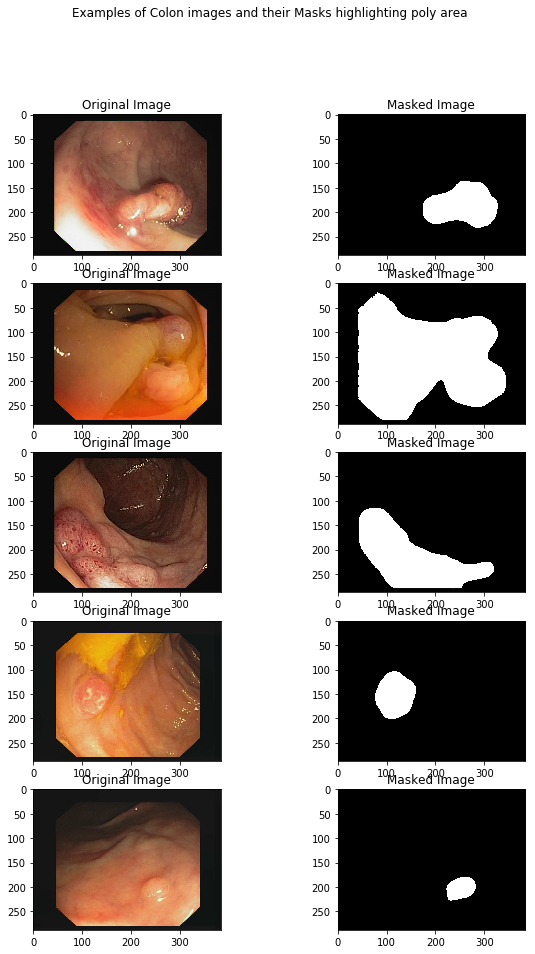

In [11]:
num_images_to_display = 5

random_choices = np.random.choice(len(training_dataset_file_paths), num_images_to_display)

plt.figure(figsize=(10, 15))

for index in range(0, num_images_to_display * 2, 2):
    image_index = random_choices[index // 2]
    input_image_pathname = training_dataset_file_paths[image_index]
    mask_image_pathname = training_dataset_masks_file_paths[image_index]
    
    plt.subplot(num_images_to_display, 2, index + 1)
    plt.imshow(mpimg.imread(input_image_pathname))
    plt.title("Original Image")
        
    example_labels = Image.open(mask_image_pathname)
    label_vals = np.unique(example_labels)
    
    plt.subplot(num_images_to_display, 2, index + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")  
    
plt.suptitle("Examples of Colon images and their Masks highlighting poly area")
plt.show()

In [12]:
def process_org_mask_image(original_file_path, mask_file_path) : 
        
    org_image_str = tf.read_file(original_file_path)
    org_image_decoded = tf.image.decode_png(org_image_str, channels=3)
    org_image_decoded.get_shape()
    
    mask_image_str = tf.read_file(mask_file_path)
    mask_image_decoded = tf.image.decode_png(mask_image_str, channels=3)
    mask_image_decoded = mask_image_decoded[:, :, 0]
    mask_image_decoded = tf.expand_dims(mask_image_decoded, axis=-1)
    
    return org_image_decoded, mask_image_decoded

### Shifting the images horizontally and vertically

In [13]:
def shift_image(input_image, mask_image, width_shift_range, height_shift_range) :
    
    if width_shift_range :
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * image_shape[1], 
                                               width_shift_range * image_shape[1])
        
    if height_shift_range :
        height_shift_range = tf.random_uniform([], 
                                              -height_shift_range * image_shape[0], 
                                               height_shift_range * image_shape[0])
        
    # translate both input image and its corresponding mask
    
    input_image = tfcontrib.image.translate(input_image, [width_shift_range, height_shift_range])
    mask_image = tfcontrib.image.translate(mask_image, [width_shift_range, height_shift_range])
    
    return input_image, mask_image

### Flipping the images randomly

In [14]:
def flip_image(horizontal_flip, input_image, mask_image) :
    
    if horizontal_flip :
        
        random_probablity = tf.random_uniform([], 0.0, 1.0)
        flip_probability = tf.less(random_probablity, 0.5)
        
        input_image, mask_image = tf.cond(flip_probability, 
                                          lambda : (tf.image.flip_left_right(input_image), tf.image.flip_left_right(mask_image)),
                                          lambda : (input_image, mask_image))

    return input_image, mask_image



### Performing data augmentation 

In [15]:
def _augementation(input_image, mask_image, resize=None, scale=1, hue_delta=0, horizontal_flip=False, width_shift_range=0, height_shift_range=0) :
    
    if resize is not None:
        # Resize both images
        mask_image = tf.image.resize_images(mask_image, resize)
        input_image = tf.image.resize_images(input_image, resize)
    
    if hue_delta : 
        tf.image.random_hue(input_image, hue_delta)
    
    input_image, mask_image = flip_image(horizontal_flip, input_image, mask_image)
    input_image, mask_image = shift_image(input_image, mask_image, width_shift_range, height_shift_range)
    
    input_image = tf.to_float(input_image) * scale
    mask_image = tf.to_float(mask_image) * scale
        
    return input_image, mask_image
    

In [16]:
def build_dataset(original_file_paths, mask_file_paths, 
                  augementation_func=functools.partial(_augementation), 
                  threads=5, batch_size=batch_size, shuffle=True) :
    
    num_training = len(original_file_paths)
        
    # Create a dataset for the original image and its corresponding mask
    # The 'from_tensor_slices' will return a sliced tensor with 'original_file_path' and 'mask_file_path'
    dataset = tf.data.Dataset.from_tensor_slices((original_file_paths, mask_file_paths))
    
    dataset = dataset.map(process_org_mask_image, num_parallel_calls=threads)
    
    
    if augementation_func.keywords is not None and 'resize' not in augementation_func.keywords:
        assert batch_size == 1, "Batching images must be of the same size"
            
    dataset = dataset.map(augementation_func, num_parallel_calls=threads)
    
    if shuffle :
        dataset.shuffle(num_training)
    
    # We should use repeat() method on our dataset for all epochs otherwise dataset will throw an 
    # error once its finsihed returning all data for one epoch.
    # The batch() method on our dataset will split the dataset into batches of provided size 'batch_size'
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset
    

### Setup training and validation dataset

In [17]:
training_dataset_config = {
    'resize': [image_shape[0], image_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
training_preprocessing_func = functools.partial(_augementation, **training_dataset_config)
training_dataset = build_dataset(training_dataset_file_paths, 
                                 training_dataset_masks_file_paths, 
                                 augementation_func=training_preprocessing_func, 
                                 batch_size=batch_size)
print(training_dataset)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
<DatasetV1Adapter shapes: ((?, 384, 288, 3), (?, 384, 288, 1)), types: (tf.float32, tf.float32)>


In [18]:
validation_dataset_config = {
    'resize': [image_shape[0], image_shape[1]],
    'scale': 1 / 255.
}
validation_preprocessing_func = functools.partial(_augementation, **validation_dataset_config)
validation_dataset = build_dataset(test_dataset_file_paths, 
                                   test_dataset_masks_file_paths,
                                   augementation_func=validation_preprocessing_func, 
                                   batch_size=batch_size)

### Let's see if our image augmentor data pipeline is producing expected results

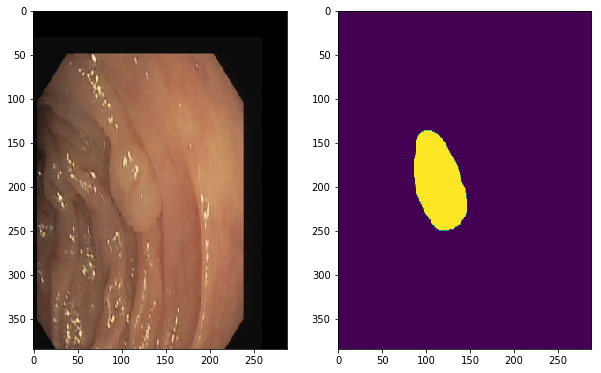

In [19]:
temp_dataset = build_dataset(training_dataset_file_paths, 
                        training_dataset_masks_file_paths, 
                        augementation_func=training_preprocessing_func, 
                        batch_size=1,
                        shuffle=False)

# Let's look at some of the augmented images
data_aug_iter = temp_dataset.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

with tf.Session() as sess: 
    
    batch_of_images, mask_images = sess.run(next_element)
    
    image = batch_of_images[0]
    mask_image = mask_images[0]
    
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    
    plt.subplot(1, 2, 2)
    plt.imshow(mask_image[:, :, 0])
    plt.show()

### Build the Model

In [15]:
def convolution_block(input, num_filters):
    
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    
    return encoder

def encoder_block_model(input, num_filters):
    encoder = convolution_block(input, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block_model(input, concat_tensor, num_filters):
    
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    return decoder

In [16]:
inputs = layers.Input(shape=image_shape)
# 256

encoder_pool0, encoder0 = encoder_block_model(inputs, 32)
# 128

encoder_pool1, encoder1 = encoder_block_model(encoder_pool0, 64)
# 64

encoder_pool2, encoder2 = encoder_block_model(encoder_pool1, 128)
# 32

encoder_pool3, encoder3 = encoder_block_model(encoder_pool2, 256)
# 16

encoder_pool4, encoder4 = encoder_block_model(encoder_pool3, 512)
# 8

center_block = convolution_block(encoder_pool4, 1024)
# center

decoder4 = decoder_block_model(center_block, encoder4, 512)
# 16

decoder3 = decoder_block_model(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block_model(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block_model(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block_model(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

### Define the model

In [13]:
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 384, 288, 3)  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 384, 288, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_27 (Batc (None, 384, 288, 32) 128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 384, 288, 32) 0           batch_normalization_v1_27[0][0]  
__________________________________________________________________________________________________
conv2d_24 

### Defining loss functions and custom metrics

In [23]:
def dice_coefficient(actual, predicted):
    smooth = 1.
    # Flatten
    actual_f = tf.reshape(actual, [-1])
    predicted_f = tf.reshape(predicted, [-1])
    intersection = tf.reduce_sum(actual_f * predicted_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(actual_f) + tf.reduce_sum(predicted_f) + smooth)
    return score

In [24]:
def dice_loss(actual, predicted):
    loss = 1 - dice_coefficient(actual, predicted)
    return loss

In [25]:
def binary_cross_entropy_dice_loss(actual, predicted):
    loss = losses.binary_crossentropy(actual, predicted) + dice_loss(actual, predicted)
    return loss

### Compile model

In [26]:
model.compile(optimizer='adam', loss=binary_cross_entropy_dice_loss, metrics=[dice_loss, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

### Training model

In [27]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_output_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [28]:
training_steps_per_epoch = int(np.ceil(training_dataset_length / float(batch_size)))
validation_steps_per_epoch = int(np.ceil(test_dataset_length / float(batch_size)))

print(training_steps_per_epoch)
print(validation_steps_per_epoch)

history = model.fit(training_dataset, 
                   steps_per_epoch=training_steps_per_epoch,
                   epochs=epochs,
                   validation_data=validation_dataset,
                   validation_steps=validation_steps_per_epoch,
                   callbacks=[model_checkpoint])

163
41
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
162/163 [============================>.] - ETA: 8s - loss: 2.8820 - dice_loss: 0.6747 - precision: 0.3957 - recall: 0.4545 
Epoch 00001: val_dice_loss improved from inf to 0.68270, saving model to ./bin/model.h5
163/163 [==============================] - 1596s 10s/step - loss: 2.8794 - dice_loss: 0.6741 - precision: 0.3967 - recall: 0.4541 - val_loss: 4.0587 - val_dice_loss: 0.6827 - val_precision: 0.3053 - val_recall: 0.5560
Epoch 2/200
162/163 [============================>.] - ETA: 8s - loss: 2.5138 - dice_loss: 0.5945 - precision: 0.4931 - recall: 0.4743 
Epoch 00002: val_dice_loss did not improve from 0.68270
163/163 [==============================] - 1571s 10s/step - loss: 2.5100 - dice_loss: 0.5935 - precision: 0.4945 - recall: 0.4753 - val_loss: 3.4245 - val_dice_loss: 0.6930 - val_precision: 0.4459 - val_recall: 0.3776
Epoch 3/200
162/163 [============================>.] - ETA: 8s - loss: 2.3704 - dice_loss: 0.

Epoch 20/200
162/163 [============================>.] - ETA: 8s - loss: 1.1304 - dice_loss: 0.2536 - precision: 0.8298 - recall: 0.7282 
Epoch 00020: val_dice_loss improved from 0.35539 to 0.34878, saving model to ./bin/model.h5
163/163 [==============================] - 1573s 10s/step - loss: 1.1300 - dice_loss: 0.2535 - precision: 0.8302 - recall: 0.7279 - val_loss: 1.6376 - val_dice_loss: 0.3488 - val_precision: 0.7530 - val_recall: 0.6396
Epoch 21/200
162/163 [============================>.] - ETA: 8s - loss: 1.0833 - dice_loss: 0.2418 - precision: 0.8423 - recall: 0.7383 
Epoch 00021: val_dice_loss improved from 0.34878 to 0.28569, saving model to ./bin/model.h5
163/163 [==============================] - 1574s 10s/step - loss: 1.0849 - dice_loss: 0.2421 - precision: 0.8422 - recall: 0.7375 - val_loss: 1.3655 - val_dice_loss: 0.2857 - val_precision: 0.7988 - val_recall: 0.7023
Epoch 22/200
162/163 [============================>.] - ETA: 8s - loss: 1.0389 - dice_loss: 0.2301 - preci

Epoch 40/200
162/163 [============================>.] - ETA: 8s - loss: 0.5595 - dice_loss: 0.1224 - precision: 0.9265 - recall: 0.8597 
Epoch 00040: val_dice_loss did not improve from 0.25195
163/163 [==============================] - 1576s 10s/step - loss: 0.5580 - dice_loss: 0.1220 - precision: 0.9268 - recall: 0.8600 - val_loss: 1.3378 - val_dice_loss: 0.2659 - val_precision: 0.8504 - val_recall: 0.6880
Epoch 41/200
162/163 [============================>.] - ETA: 8s - loss: 0.5211 - dice_loss: 0.1139 - precision: 0.9286 - recall: 0.8690 
Epoch 00041: val_dice_loss improved from 0.25195 to 0.21044, saving model to ./bin/model.h5
163/163 [==============================] - 1577s 10s/step - loss: 0.5224 - dice_loss: 0.1141 - precision: 0.9282 - recall: 0.8687 - val_loss: 1.0397 - val_dice_loss: 0.2104 - val_precision: 0.9080 - val_recall: 0.7374
Epoch 42/200
162/163 [============================>.] - ETA: 8s - loss: 0.5255 - dice_loss: 0.1145 - precision: 0.9297 - recall: 0.8682 
Epoch

Epoch 60/200
162/163 [============================>.] - ETA: 8s - loss: 0.3678 - dice_loss: 0.0814 - precision: 0.9493 - recall: 0.9057 
Epoch 00060: val_dice_loss did not improve from 0.15930
163/163 [==============================] - 1575s 10s/step - loss: 0.3683 - dice_loss: 0.0814 - precision: 0.9488 - recall: 0.9060 - val_loss: 0.8347 - val_dice_loss: 0.1653 - val_precision: 0.9357 - val_recall: 0.7861
Epoch 61/200
162/163 [============================>.] - ETA: 8s - loss: 0.4122 - dice_loss: 0.0915 - precision: 0.9410 - recall: 0.8955 
Epoch 00061: val_dice_loss did not improve from 0.15930
163/163 [==============================] - 1574s 10s/step - loss: 0.4128 - dice_loss: 0.0916 - precision: 0.9409 - recall: 0.8953 - val_loss: 1.0767 - val_dice_loss: 0.2018 - val_precision: 0.8885 - val_recall: 0.7520
Epoch 62/200
162/163 [============================>.] - ETA: 8s - loss: 0.3575 - dice_loss: 0.0799 - precision: 0.9475 - recall: 0.9079 
Epoch 00062: val_dice_loss did not improv

Epoch 80/200
162/163 [============================>.] - ETA: 8s - loss: 0.4028 - dice_loss: 0.0875 - precision: 0.9430 - recall: 0.8968 
Epoch 00080: val_dice_loss did not improve from 0.13685
163/163 [==============================] - 1593s 10s/step - loss: 0.4035 - dice_loss: 0.0876 - precision: 0.9423 - recall: 0.8972 - val_loss: 1.7129 - val_dice_loss: 0.3418 - val_precision: 0.7674 - val_recall: 0.6397
Epoch 81/200
162/163 [============================>.] - ETA: 9s - loss: 0.3128 - dice_loss: 0.0703 - precision: 0.9523 - recall: 0.9192 
Epoch 00081: val_dice_loss did not improve from 0.13685
163/163 [==============================] - 1630s 10s/step - loss: 0.3126 - dice_loss: 0.0702 - precision: 0.9521 - recall: 0.9196 - val_loss: 1.1193 - val_dice_loss: 0.1986 - val_precision: 0.9043 - val_recall: 0.7592
Epoch 82/200
162/163 [============================>.] - ETA: 8s - loss: 0.2657 - dice_loss: 0.0599 - precision: 0.9610 - recall: 0.9295 
Epoch 00082: val_dice_loss did not improv

Epoch 100/200
162/163 [============================>.] - ETA: 8s - loss: 0.3983 - dice_loss: 0.0878 - precision: 0.9432 - recall: 0.9001 
Epoch 00100: val_dice_loss did not improve from 0.13418
163/163 [==============================] - 1575s 10s/step - loss: 0.3998 - dice_loss: 0.0880 - precision: 0.9422 - recall: 0.9005 - val_loss: 1.2154 - val_dice_loss: 0.2494 - val_precision: 0.8761 - val_recall: 0.7068
Epoch 101/200
162/163 [============================>.] - ETA: 8s - loss: 0.2806 - dice_loss: 0.0622 - precision: 0.9563 - recall: 0.9263 
Epoch 00101: val_dice_loss did not improve from 0.13418
163/163 [==============================] - 1572s 10s/step - loss: 0.2806 - dice_loss: 0.0622 - precision: 0.9561 - recall: 0.9265 - val_loss: 0.8632 - val_dice_loss: 0.1484 - val_precision: 0.9431 - val_recall: 0.7786
Epoch 102/200
162/163 [============================>.] - ETA: 8s - loss: 0.2086 - dice_loss: 0.0475 - precision: 0.9703 - recall: 0.9377 
Epoch 00102: val_dice_loss did not imp

Epoch 120/200
162/163 [============================>.] - ETA: 8s - loss: 0.1709 - dice_loss: 0.0392 - precision: 0.9764 - recall: 0.9465 
Epoch 00120: val_dice_loss did not improve from 0.11827
163/163 [==============================] - 1574s 10s/step - loss: 0.1710 - dice_loss: 0.0393 - precision: 0.9763 - recall: 0.9466 - val_loss: 0.8567 - val_dice_loss: 0.1407 - val_precision: 0.9632 - val_recall: 0.7987
Epoch 121/200
162/163 [============================>.] - ETA: 8s - loss: 0.1781 - dice_loss: 0.0407 - precision: 0.9742 - recall: 0.9469 
Epoch 00121: val_dice_loss did not improve from 0.11827
163/163 [==============================] - 1574s 10s/step - loss: 0.1782 - dice_loss: 0.0407 - precision: 0.9741 - recall: 0.9470 - val_loss: 0.8231 - val_dice_loss: 0.1328 - val_precision: 0.9444 - val_recall: 0.8159
Epoch 122/200
162/163 [============================>.] - ETA: 8s - loss: 0.1798 - dice_loss: 0.0411 - precision: 0.9737 - recall: 0.9482 
Epoch 00122: val_dice_loss did not imp

Epoch 140/200
162/163 [============================>.] - ETA: 8s - loss: 0.1473 - dice_loss: 0.0339 - precision: 0.9794 - recall: 0.9538 
Epoch 00140: val_dice_loss did not improve from 0.11827
163/163 [==============================] - 1576s 10s/step - loss: 0.1474 - dice_loss: 0.0339 - precision: 0.9793 - recall: 0.9539 - val_loss: 0.7400 - val_dice_loss: 0.1218 - val_precision: 0.9673 - val_recall: 0.8150
Epoch 141/200
162/163 [============================>.] - ETA: 8s - loss: 0.1468 - dice_loss: 0.0338 - precision: 0.9796 - recall: 0.9525 
Epoch 00141: val_dice_loss did not improve from 0.11827
163/163 [==============================] - 1574s 10s/step - loss: 0.1468 - dice_loss: 0.0338 - precision: 0.9796 - recall: 0.9525 - val_loss: 0.7697 - val_dice_loss: 0.1244 - val_precision: 0.9611 - val_recall: 0.8215
Epoch 142/200
162/163 [============================>.] - ETA: 8s - loss: 0.2262 - dice_loss: 0.0492 - precision: 0.9698 - recall: 0.9351 
Epoch 00142: val_dice_loss did not imp

Epoch 160/200
162/163 [============================>.] - ETA: 8s - loss: 0.1370 - dice_loss: 0.0315 - precision: 0.9813 - recall: 0.9540 
Epoch 00160: val_dice_loss improved from 0.11599 to 0.11380, saving model to ./bin/model.h5
163/163 [==============================] - 1577s 10s/step - loss: 0.1371 - dice_loss: 0.0315 - precision: 0.9813 - recall: 0.9540 - val_loss: 0.7103 - val_dice_loss: 0.1138 - val_precision: 0.9556 - val_recall: 0.8354
Epoch 161/200
162/163 [============================>.] - ETA: 8s - loss: 0.1474 - dice_loss: 0.0340 - precision: 0.9795 - recall: 0.9512 
Epoch 00161: val_dice_loss did not improve from 0.11380
163/163 [==============================] - 1574s 10s/step - loss: 0.1477 - dice_loss: 0.0340 - precision: 0.9795 - recall: 0.9510 - val_loss: 0.7447 - val_dice_loss: 0.1227 - val_precision: 0.9312 - val_recall: 0.8413
Epoch 162/200
162/163 [============================>.] - ETA: 8s - loss: 0.1396 - dice_loss: 0.0322 - precision: 0.9809 - recall: 0.9530 
Ep

Epoch 180/200
162/163 [============================>.] - ETA: 8s - loss: 0.1183 - dice_loss: 0.0275 - precision: 0.9847 - recall: 0.9590 
Epoch 00180: val_dice_loss did not improve from 0.10528
163/163 [==============================] - 1577s 10s/step - loss: 0.1184 - dice_loss: 0.0275 - precision: 0.9847 - recall: 0.9591 - val_loss: 0.7770 - val_dice_loss: 0.1166 - val_precision: 0.9626 - val_recall: 0.8220
Epoch 181/200
162/163 [============================>.] - ETA: 8s - loss: 0.1699 - dice_loss: 0.0378 - precision: 0.9759 - recall: 0.9482 
Epoch 00181: val_dice_loss did not improve from 0.10528
163/163 [==============================] - 1579s 10s/step - loss: 0.1706 - dice_loss: 0.0379 - precision: 0.9757 - recall: 0.9482 - val_loss: 2.1225 - val_dice_loss: 0.3794 - val_precision: 0.5676 - val_recall: 0.7621
Epoch 182/200
162/163 [============================>.] - ETA: 8s - loss: 0.4872 - dice_loss: 0.1022 - precision: 0.9337 - recall: 0.8763 
Epoch 00182: val_dice_loss did not imp

Epoch 200/200
162/163 [============================>.] - ETA: 8s - loss: 0.2522 - dice_loss: 0.0561 - precision: 0.9632 - recall: 0.9286 
Epoch 00200: val_dice_loss did not improve from 0.10528
163/163 [==============================] - 1578s 10s/step - loss: 0.2519 - dice_loss: 0.0561 - precision: 0.9632 - recall: 0.9287 - val_loss: 0.7353 - val_dice_loss: 0.1347 - val_precision: 0.9137 - val_recall: 0.8513


### Visualize the training process

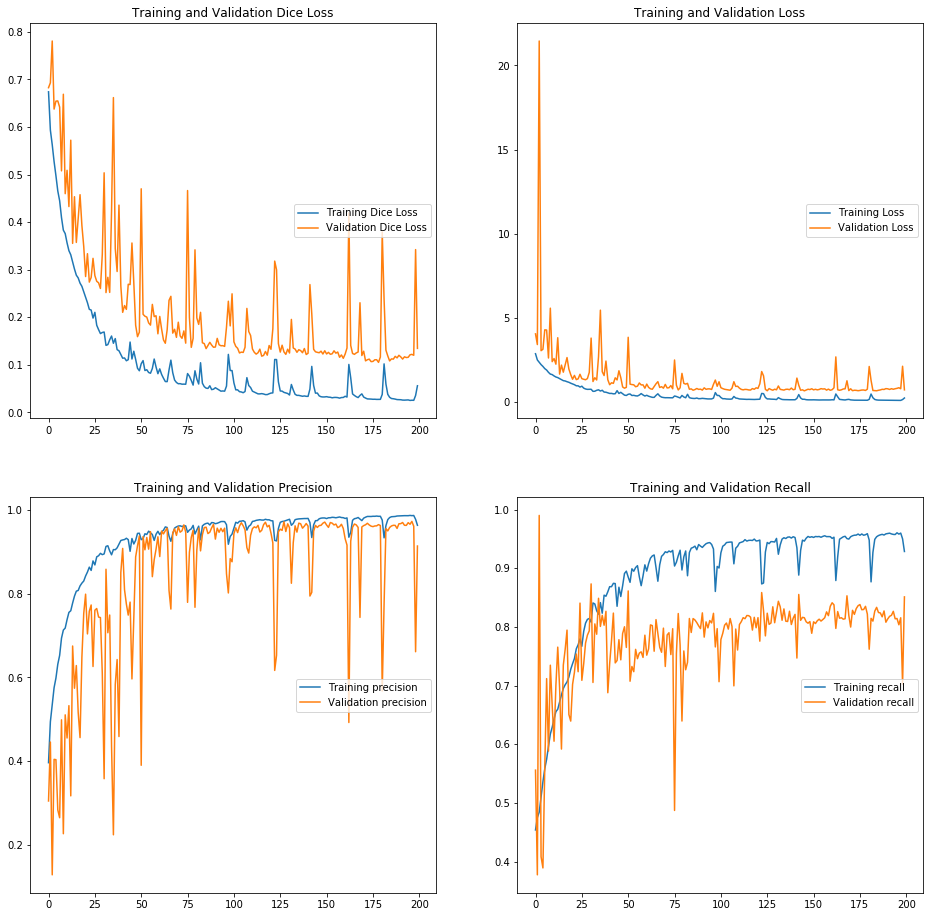

In [29]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

epochs_range = range(epochs)

plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='right')
plt.title('Training and Validation Dice Loss')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='right')
plt.title('Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(epochs_range, precision, label='Training precision')
plt.plot(epochs_range, val_precision, label='Validation precision')
plt.legend(loc='right')
plt.title('Training and Validation Precision')

plt.subplot(2, 2, 4)
plt.plot(epochs_range, recall, label='Training recall')
plt.plot(epochs_range, val_recall, label='Validation recall')
plt.legend(loc='right')
plt.title('Training and Validation Recall')

plt.show()

### Make Predictions

In [30]:
del model

In [31]:
model = models.load_model(model_output_path, custom_objects={'binary_cross_entropy_dice_loss': binary_cross_entropy_dice_loss, 'dice_loss': dice_loss})

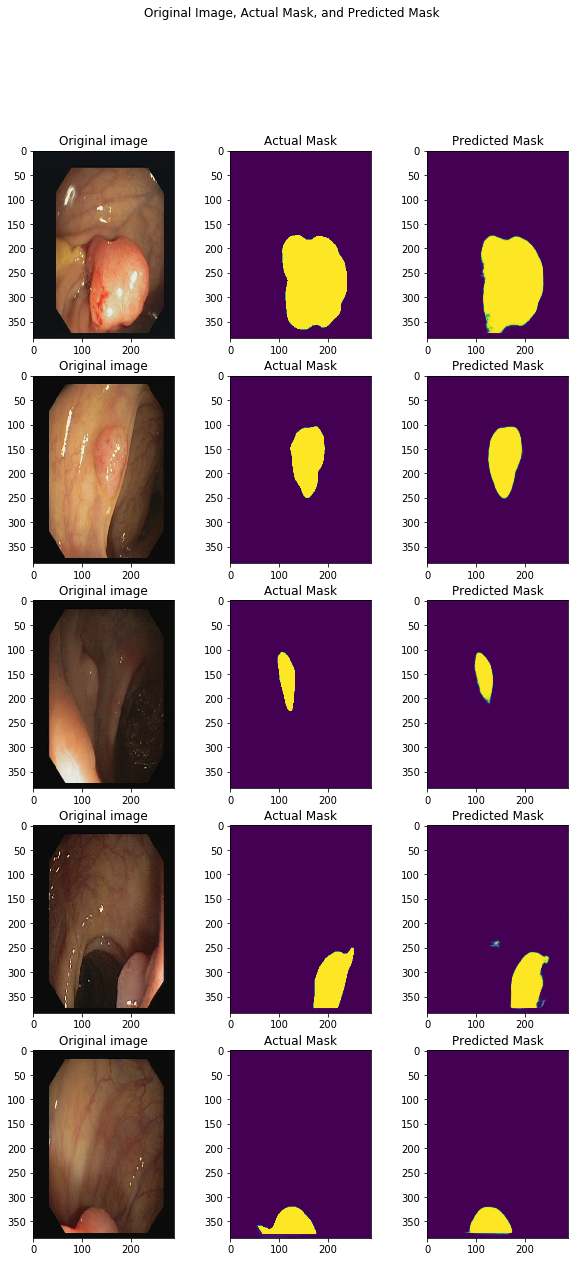

In [32]:
# Predict and visualize 
data_aug_iter = validation_dataset.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))

for i in range(5):
    
    batch_of_images, mask = tf.keras.backend.get_session().run(next_element)
    image = batch_of_images[0]
    predicted_mask = model.predict(batch_of_images)[0]
    
    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(image)
    plt.title("Original image")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(mask[0, :, :, 0])
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_mask[:, :, 0])
    plt.title("Predicted Mask")

plt.suptitle("Original Image, Actual Mask, and Predicted Mask")
plt.show()